In [1]:
import data, training, eval
import wandb, torch

In [2]:
wandb.login()

#Laptop
#root = "C:/Users/20182573/Documents/CityScapes"

#Desktop
root = 'E:/Cityscapes'


lr_rate = 3e-4
epochs = 10
batch_size = 8
subsize = (256, 512)
wenb = False



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: svenbbs. Use `wandb login --relogin` to force relogin


In [3]:
transforms = data.getTransforms(subsize=subsize)
train_set, val_set = data.loadData(root=root, transforms=transforms,verbose=True)
train_dl, val_dl = data.getDataLoader(train_set=train_set, val_set=val_set, batch_size=batch_size)

Size of the training set: 2380
Size of the validation set: 595


In [4]:
model, loss_fn, optimizer, device = training.buildModel(lr_rate=lr_rate, verbose=True)

Working on device: cuda:0


In [5]:
if wenb:

    run = wandb.init(
        # Set the project where this run will be logged
        project="CS_challenge", name="3.0",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": {lr_rate},
            "epochs": {epochs},
            "Batch_size": {batch_size},
            "model version": 0.0,
            "resize": {subsize},
            "Optimizer": 'Adam',
        },
    )

In [6]:
#training.trainModel(train_dl,val_dl,model,loss_fn,optimizer,device,epochs,wenb,False)


In [7]:
if wenb:
    run.finish()

In [8]:
#torch.save(model.state_dict(), "model.pth")

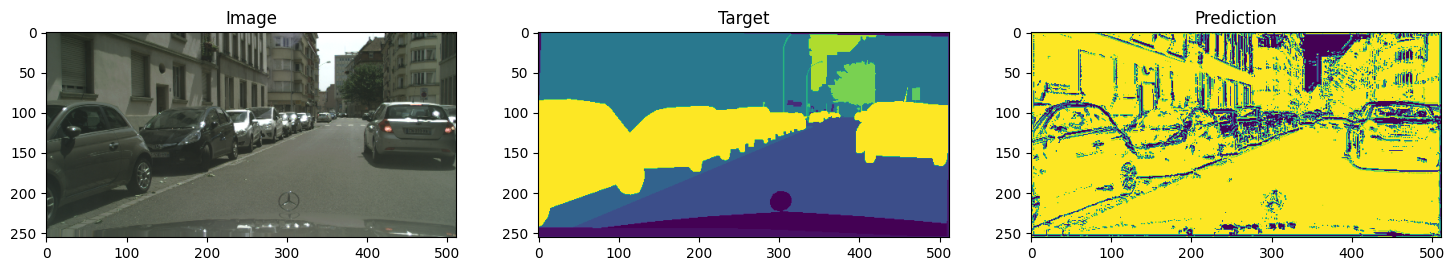

In [9]:
image, target, prediction = eval.getImageTargetAndPrediction(val_dl,model)
eval.showImageTargetAndPrediction(image, target, prediction)

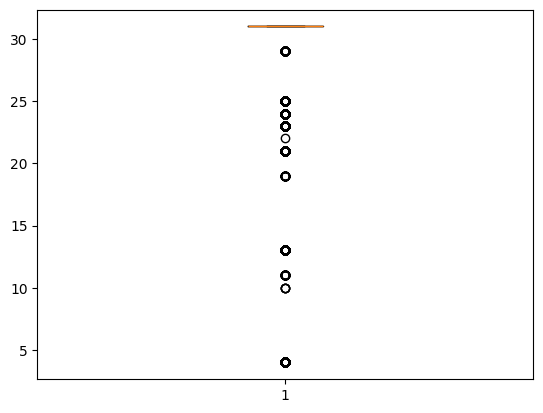

In [10]:
eval.showPixelValues(prediction)

In [11]:
batch = next(iter(val_dl))

In [12]:
import process_data

In [19]:
input = batch[0][0].unsqueeze(0).float().cuda()
model.eval()
pred = model(input)

pred_np = process_data.postprocess(pred, (1024,2048))

In [17]:
import numpy as np
import matplotlib.pyplot as plt
np.shape(pred_np)

(256, 512)

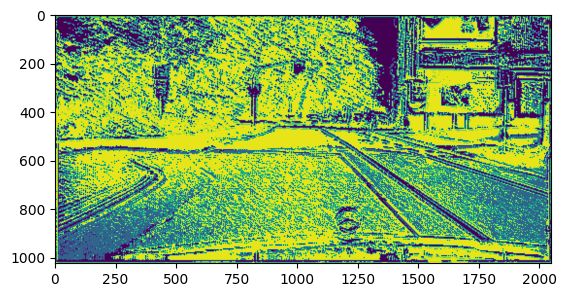

In [20]:
plt.imshow(pred_np)